In [1]:
import numpy as np
import pandas as pd
import json
from urllib.request import urlopen
import sqlite3
import string

import seaborn as sns
import matplotlib.pyplot as plt

#load the statistical libraries
from statsmodels.stats import diagnostic
from scipy import stats
import ast

#NLP libraries
import spacy, nltk, gensim, sklearn
import pyLDAvis.gensim_models


#Scikit imports
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle


from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

/Users/alicia/opt/anaconda3/envs/ada/lib/python3.8/site-packages/gensim/similarities/__init__.py:15: UserWarning: The gensim.similarities.levenshtein submodule is disabled, because the optional Levenshtein package <https://pypi.org/project/python-Levenshtein/> is unavailable. Install Levenhstein (e.g. `pip install python-Levenshtein`) to suppress this warning.
  warnings.warn(msg)


# General information Remark

### In the loading part we will recover data from 2015 to 2020, however, first visulation (part III) will only be on the data from 2020.

# I- Load the data

### Load Quotebank data

First, let's recover the quotations of interest : as our project is based on the caracterisation of the speaker, we decide to pre-select the quotations that are related to a speaker (i.e speaker value is different from 'None'). 
Moreover, we select the quotations whose subject is related to climate change : to do so we will recover a list of keyword related to climate subject by analyzing wwith NLP the dataset train_climate.tcsv. Then, we select quotes that contains at least one of these words(cf chunk_filtering method).

> #### A/ Recovering of the keyword list 

In [2]:
data1 = pd.read_csv('data/Wiki_train.tsv', sep='\t')
data2=pd.read_csv('data/train_1.tsv', sep='\t')

In [4]:
data1.drop(labels = ['id', 'paragraph', 'title'], axis=1, inplace=True)
data2.drop(labels = ['id', 'paragraph', 'title'], axis=1, inplace=True)

In [5]:
subdata = pd.concat([data1, data2])

> ##### Creation of our bag of word 

In [6]:
vectorizer = CountVectorizer(stop_words = 'english',ngram_range=(1, 2),lowercase=False)


#create bag of words features
X = vectorizer.fit_transform(subdata.sentence)


print('Number of samples:',X.toarray().shape[0])
print('Number of features:',X.toarray().shape[1])

#mask and convert to int climate
Y = np.array(subdata.label)



print(Y.shape)
print(X.shape)
#shuffle the data

X, Y = shuffle(X, Y, random_state=0)



#split into training and test set
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

Number of samples: 6000
Number of features: 75261
(6000,)
(6000, 75261)


In [7]:
tfidf_transformer = TfidfTransformer()
X_train_tfidf = tfidf_transformer.fit_transform(X_train)
X_test_tfidf=tfidf_transformer.fit_transform(X_test)
#transform the count matrix X_train to a normalized tf-idf representation
X_train_tfidf.shape 
X_test_tfidf

<1200x75261 sparse matrix of type '<class 'numpy.float64'>'
	with 26161 stored elements in Compressed Sparse Row format>

In [8]:
train = [X_train, X_train_tfidf]
test = [X_test, X_test_tfidf]

In [9]:
C = [0.01, 0.1, 1, 10, 100, 1000, 10000] 


param_grid = dict(C=C) 

logistic = LogisticRegression(solver = 'lbfgs', penalty = 'l2') 

grid = GridSearchCV(estimator=logistic, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 10) 

for features in (train) : 
    grid_result = grid.fit(features, Y_train) 
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_) 

Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best Score:  0.9394273127753303
Best Params:  {'C': 0.1}
Fitting 10 folds for each of 7 candidates, totalling 70 fits
Best Score:  0.9443832599118943
Best Params:  {'C': 10}


In [10]:
penalty = ['l1', 'l2', 'elasticnet'] 
alpha = [1e-4, 1e-3, 1e-2, 1e-1, 1e0, 10]
loss=['log', 'hinge']
max_iter=[1000, 10000, 100000, 1e6]
n_jobs = [-1]


param_grid = dict(penalty=penalty, 
alpha=alpha,loss=loss,max_iter=max_iter, n_jobs=n_jobs) 

logistic = SGDClassifier() 

grid = GridSearchCV(estimator=logistic, param_grid=param_grid, scoring='roc_auc', verbose=1, n_jobs=-1, cv = 10) 

for features in (train) : 
    grid_result = grid.fit(features, Y_train) 
    print('Best Score: ', grid_result.best_score_) 
    print('Best Params: ', grid_result.best_params_) 

Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best Score:  0.9285199932226365
Best Params:  {'alpha': 0.001, 'loss': 'hinge', 'max_iter': 100000, 'n_jobs': -1, 'penalty': 'l2'}
Fitting 10 folds for each of 144 candidates, totalling 1440 fits
Best Score:  0.9418756353778381
Best Params:  {'alpha': 0.0001, 'loss': 'log', 'max_iter': 1000000.0, 'n_jobs': -1, 'penalty': 'l2'}


In [11]:
clf = LogisticRegression(random_state=0, solver='lbfgs',C = 10, penalty='l2').fit(X_train_tfidf, Y_train)
predicted = clf.predict(X_test_tfidf)
print('Accuracy:{}'.format(np.mean(predicted == Y_test)))

Accuracy:0.9508333333333333


In [12]:
coefs=clf.coef_[0]
top_three = np.argpartition(coefs, -30)[-30:]
print(np.array(vectorizer.get_feature_names_out())[top_three])

['gases' 'fuels' 'diesel' 'greenhouse gases' 'levels' 'increase' 'gas'
 'warmer' 'carbon tax' '2010' 'climate change' 'precipitation' 'emission'
 'change' 'glaciers' 'policy' 'GHG' 'global warming' 'global' 'greenhouse'
 'cap' 'temperatures' 'Glacier' 'warming' 'increased' 'fuel' 'carbon'
 'climate' 'Climate' 'emissions']


In [13]:
clf_sdg = SGDClassifier(loss="log", penalty="l2", alpha = 0.0001,   max_iter=1e6, n_jobs=-1).fit(X_train_tfidf, Y_train)
predicted = clf_sdg.predict(X_test_tfidf)
print('Accuracy:{}'.format(np.mean(predicted == Y_test)))

Accuracy:0.95


In [14]:
coefs_sdg=clf_sdg.coef_[0]
top_three_sdg = np.argpartition(coefs_sdg, -30)[-30:]

print(np.array(vectorizer.get_feature_names_out())[top_three_sdg])

['increase' '2010' 'precipitation' 'CO' 'gases' 'temperature'
 'greenhouse gases' 'change' 'levels' 'temperatures' 'warmer' 'warming'
 'emission' 'Climate' 'emissions' 'increased' 'policy' 'GHG' 'climate'
 'cap' 'diesel' 'greenhouse' 'fuel' 'carbon' 'fuels' 'global warming'
 'global' 'glaciers' 'gas' 'Glacier']


In [16]:
keywords = np.array(vectorizer.get_feature_names_out())[top_three]
keywords=np.delete(keywords, [4, 5, 9, 15, 18, 24])

In [17]:
keywords

array(['gases', 'fuels', 'diesel', 'greenhouse gases', 'gas', 'warmer',
       'carbon tax', 'climate change', 'precipitation', 'emission',
       'change', 'glaciers', 'GHG', 'global warming', 'greenhouse', 'cap',
       'temperatures', 'Glacier', 'warming', 'fuel', 'carbon', 'climate',
       'Climate', 'emissions'], dtype=object)

> #### B/ Recover climate quotation from Quotebank

In [3]:
def chunk_filtering(chunk, lst):
    template=[] #Creation of an empty list :it's always cheaper to append to a list and create a DataFrame than append on a empty dataframe.
    for i in lst: 
        template.append(chunk.loc[chunk["quotation"].apply(lambda x : i in x) & 
                                  chunk["speaker"].apply(lambda x: x!= "None")&
                                  chunk["qids"].apply(lambda x: len(np.array(x))==1)].drop(['phase'], axis=1))
        #Select quotations with value in speaker column different from 'None' and quotations containing the key word and drop Phase column. 
        #As the speaker is identified by their name and not their QID, we select the ones that have a unique QID to facilitate our analysis.
        
    return (pd.concat(template, ignore_index=True))# return a dataframe with our data of interest

In [6]:
dico={} #We create a dictonary to loop over our years. 
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico[date] = pd.read_json(f'data/quotes-{date}.json.bz2', lines=True, compression='bz2', chunksize=1000)

In [7]:
for date, df in dico.items() : 
    for i, chunk in enumerate(df) : 
        chunk_clean=chunk_filtering(chunk, keywords) #recover interested row of the chunk
        header = i == 0 #we kept the name of the column only for the first chunk
        mode = 'w' if i == 0 else 'a' # For appending data to an existing CSV file (so for every chunk exepct the first one), 
                                        #we can use mode = a
            
        chunk_clean.to_csv(path_or_buf=f"data/clean_quotes-{date}.bz2",compression='bz2',header=header, mode=mode, index = False ) #Load to CSV.

In [36]:
dico_clean={} 
length = 0
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico_clean[date] = pd.read_csv(f'data/clean_quotes-{date}.bz2', compression='bz2')
    length += len(dico_clean[date]) #The length is used here to obtain the total number of quotes. 

In [9]:
print(" At result, we extracted {} quotes fromes quotebank data".format(length))

 At result, we extracted 131472 quotes fromes quotebank data


Even with key_word selection we success to extract a satisfying quantity of data from the Quotebank data. 

> ##### B/ Select data representative for climate septic

We want to asses climate scepticism among our speakers. We selected 10 speakers that are said to be climate sceptic according to https://www.businessinsider.com/the-ten-most-important-climate-change-skeptics-2009-7?IR=T#dont-miss-11. We are going to create a list of keywords based on quotes from these speakers. 

In [10]:
lst = ['Freeman Dyson', 'Bjorn Lomborg', 'Myron Ebell', 'Kiminori Itoh', 'Ivar Giaever', 
       'Will Happer', 'Ian Plimer', 'Michael Chrichton', 'Alan Carlin', 'Patrick Michaels'] #list of the name taken from the article
#iteration in the list of name in order to find if our people of interest are in our quotes list and 
#we then create one df per year with their correspondings quotes

template = []
dico={2020 : quotes_2020, 2019 : quotes_2019, 2018 : quotes_2018, 2017 : quotes_2017, 2016 : quotes_2016, 2015 : quotes_2015}

for key, quotes in dico.items():
    for i in lst: #Here, we are establishing the list of quotes said by our speakers of interest.
        template.append(quotes.loc[quotes['speaker'].apply(lambda x : i == x)])  
    df_quotes= pd.concat(template, ignore_index=True) #return a dataframe containg all of our quotes of interest.

In [15]:
import nltk
import nltk.corpus
from nltk.tokenize import word_tokenize 
nltk.download('punkt')
from nltk.probability import FreqDist
nltk.download('words')
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')

#two functions to asses the highest frequency of word appearance
a = set(stopwords.words('english'))

def remov_punc(lst): #removes the punctuations from a sentence
    punc = '''!()-[]{};:'"\,<>./?@#$%^&*_°~''' #list of punctuations 
    remov_punc = []
    t = 0
    
    for i in lst :
        t=t+1
        for d in i:
            if d in punc:
                i = i.replace(d, " ")
        remov_punc.append(i)
    return remov_punc
    
def words_freq(lst): #calculate each word frequency
    ls=[]
    for i in lst: 
        text = i
        text1 = word_tokenize(text.lower())
        imp_words = [x for x in text1 if x not in a]
        ls.append(imp_words)
    return ls

def words__highest_freq(lst): #return the highest word frequency
    ls_freq = []
    for i in lst: 
        fdist = FreqDist(i)
        fdist1 = fdist.most_common(1)
        ls_freq.append(fdist1)
    return ls_freq #this is a list with the highest frequency for each most written words



[nltk_data] Downloading package punkt to
[nltk_data]     /Users/virginiegarnier/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     /Users/virginiegarnier/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/virginiegarnier/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [16]:
#construct lists with all the words frquency
list_quotes=df_quotes['quotation'].tolist()
w_freq= words_freq(remov_punc(list_quotes))
w_h_freq = words__highest_freq(w_freq)
w_h_freq

keywords_sceptic = []

for i in w_h_freq: #keep the highest frequency 
    for d in i: 
        if d[1] >=3 : 
            if d[0] not in keywords_sceptic:
                keywords_sceptic.append(d[0])
        
keywords_sceptic #our list of keywords according to their representation in the climate sceptic speaker quotations

['science',
 'increasing',
 'local',
 'demonstration',
 'climate',
 'energy',
 'emissions',
 'power',
 'degrees',
 'percent',
 'c',
 'silly',
 'paris',
 'co2',
 'consensus',
 'global',
 'effects',
 'models',
 'r',
 'ipcc',
 'years',
 'year']

As we can see, our list contains characters, and worlds there were already present in the keywords 
used to find climate-change related quote. We will remove them from this list. We are aware that 
this method is very unprecised and biased, a large part of our M3 will be dedicated to quote sorting 
based on climate change-scepticism criteria. 

In [18]:
list_to_remove=['c', 'r', 'climate', 'energy', 'co2'] #List of worlds we want to remove
for world in list_to_remove:
    keywords_sceptic.remove(world)

In [19]:
keywords_sceptic #Final keywords to select our climate change skeptic quotes. 

['science',
 'increasing',
 'local',
 'demonstration',
 'emissions',
 'power',
 'degrees',
 'percent',
 'silly',
 'paris',
 'consensus',
 'global',
 'effects',
 'models',
 'ipcc',
 'years',
 'year']

In [20]:
dico={}
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico[date] = pd.read_json(f'data/quotes-{date}.json.bz2', lines=True, compression='bz2', chunksize=1000)

Now we load our data with this new list of keywords. We use the same technique as above. 

In [21]:
for date, df in dico.items() : 
    for i, chunk in enumerate(df) : 
        chunk_clean=chunk_filtering(chunk, keywords_sceptic) #recover interested row of the chunk
        header = i == 0 #we kept the name of the column only for the first chunk
        mode = 'w' if i == 0 else 'a' # For appending data to an existing CSV file (so for every chunk exepct the first one), 
                                        #we can use mode = a
            
        chunk_clean.to_csv(path_or_buf=f"data/clean_quotes_sceptic-{date}.bz2",compression='bz2',header=header, mode=mode, index = False )

In [22]:
dico_skeptic={}
length=0
for date in [2020, 2019, 2018, 2017, 2016, 2015]:
    dico_skeptic[date] = pd.read_csv(f'data/clean_quotes_sceptic-{date}.bz2', compression='bz2')
    length += len(dico_skeptic[date])

In [24]:
print(" At result, we extracted {} quotes fromes quotebank data".format(length))

 At result, we extracted 6503877 quotes fromes quotebank data


As we can see, we have a very large number of quotes compared to our climate-related set. This highlights problems in our methods to identify climate change skeptical quotes. Once again, a large portion of our M3 will be dedicated to improve on that. 

## Load additional data Relative to speakers

### Extracted labels from QID 

The provided speaker_attributes.parquet file contains attributes in terms of QIDs, thereby being uninterpretable by humans (df_qid).
To map the QIDs to meaningful labels, we used the provided wikidata_labels_descriptions_quotebank.csv.bz2 containing the label and value for the respective QID containing the df_qid (df_label_qid).
By combining the information of both we can obtained usefull information about speakers. 

#### *Load parquet file*

In [25]:
#Loading our speakers attribute dataset, and the dataset necessary to interpret our QIDs.
df_qid = pd.read_parquet("speaker_attributes.parquet",engine= "pyarrow" )
df_label_qid = pd.read_csv('data/wikidata_labels_descriptions_quotebank.csv.bz2', compression='bz2', index_col='QID')

#### *Somes visualisation and sort of the parquet file*

First let's check if the identifier are unique.

In [26]:
df_qid.id.is_unique

True

Before extract the label of QID, let's check which column we want to keep in frame with our project.

In [27]:
df_qid.head(3)

,aliases,date_of_birth,nationality,gender,lastrevid,ethnic_group,US_congress_bio_ID,occupation,party,academic_degree,id,label,candidacy,type,religion
0,"[Washington, President Washington, G. Washingt...",[+1732-02-22T00:00:00Z],"[Q161885, Q30]",[Q6581097],1395141751,None,W000178,"[Q82955, Q189290, Q131512, Q1734662, Q294126, ...",[Q327591],None,Q23,George Washington,"[Q698073, Q697949]",item,[Q682443]
1,"[Douglas Noel Adams, Douglas Noël Adams, Dougl...",[+1952-03-11T00:00:00Z],[Q145],[Q6581097],1395737157,[Q7994501],None,"[Q214917, Q28389, Q6625963, Q4853732, Q1884422...",None,None,Q42,Douglas Adams,None,item,None
2,"[Paul Marie Ghislain Otlet, Paul Marie Otlet]",[+1868-08-23T00:00:00Z],[Q31],[Q6581097],1380367296,None,None,"[Q36180, Q40348, Q182436, Q1265807, Q205375, Q...",None,None,Q1868,Paul Otlet,None,item,None


Let's verify that academic_degree has revelant values.

In [28]:
print("There's no academic degree revelant value ? {}".format(all(df_qid.academic_degree.isna())))

There's no academic degree revelant value ? False


It seems that academic degree values are revelant, we decided to drop lastrevid, US_congress_bio_ID, type, Alisiase as they will not be used in our project.

In [29]:
df_qid.drop(['lastrevid', 'US_congress_bio_ID', 'type', 'aliases'], axis=1, inplace=True)

#### *Transformation of the df_qid with the label value from df_label_qid*

In [30]:
#We found that one of the QID was deleted from Wikidata. We will start by dropping this value, so that it does not distrurb our labelling. 

def transform(y):
    if y is None: return None
    x = set(y)
    x.discard("Q99753484")
    return np.array(list(x))
    
df_qid['occupation']=df_qid['occupation'].apply(lambda y : transform(y))

In [31]:
#We found out that some of the QIDs used in the speaker attribute file are actually redirection from an original QID. 
#We will manulally add their corresponding information using the orginal QID. We found the corespondance manualy between the two. 
#Here, there are in order, respectively the redirection QID, and its corresponding original one. One of he QID was only present 
#as a redirection, so we manually added this one (Q3186984), and its corresponding info. 

redirect_QID=['Q3268166', 'Q11815360', 'Q12014399', 'Q16287483',
              'Q20432251', 'Q21550646', 'Q13365117', 'Q13424794',
             'Q1248362', 'Q6859927', 'Q15145782',
             'Q15991263', 'Q12455619', 'Q5568256', 
             'Q6363085', 'Q11819457', 'Q12334852', 'Q15145783']
actual_QID=['Q1113899', 'Q1919436', 'Q250867', 'Q6051619',
             'Q26934816', 'Q18431816', 'Q12840545', 'Q5157338',
            'Q3455803', 'Q715222', 'Q1052281',
            'Q2743689', 'Q7019111', 'Q3738699', 
            'Q380075', 'Q3391743', 'Q476246', 'Q2449503']


lst=[['Journalist', 'monthly magazine of the United Kingdom‘s National Union of Journalists (NUJ)']]
indexes=['Q3186984']
col=['Label', 'Description']
for i in range(len(redirect_QID)):
    lst.append([df_label_qid.loc[actual_QID[i]]['Label'], 
                df_label_qid.loc[actual_QID[i]]['Description']])
    indexes.append(redirect_QID[i])

additional_df= pd.DataFrame(lst, columns= col, index=indexes)
df_label=df_label_qid.append(additional_df, ignore_index= False)

In [32]:
#Applying the function to every column containing QIDs. 
cols=['nationality', 'gender', 'ethnic_group','occupation', 'party', 'academic_degree', 'candidacy', 'religion'] #List of columns 
#containing QID to be replace

df_qid[cols] = df_qid[cols].applymap(lambda d: d if d is not None else []) #Replacing every None value with an empty list for futur analysis.
df_qid[cols] = df_qid[cols].applymap(lambda y: [df_label.loc[Q].Label for Q in y]) #Replacing QIDs with their corresponding label.

### Let's have additional data (skeptic/climate)

Now, we want to see which speakers said quotes that we consider as climate-related and climate change sceptical. We will match speaker from the df_qid with a value septic/climate. We will add two boolean columns to our dataframe df_qid: one for climate-related, and one for climate change sceptical. In order to do that, we will select every QID that appears in our list of climate-related-quotes and climat-change-sceptical quotes

#### *Qid_climate list*

In [37]:
qid_climate=[]

#iteration in the dico_clean containing extracted files for climate involved quotes
for key, file in dico_clean.items() :
    qid_climate.append(file.drop_duplicates(['qids'], keep='first')['qids'].map(lambda y : ast.literal_eval(y)[0]).tolist()) #add unique QIDs from each file
qid_climate=set(item for sublist in qid_climate for item in sublist)#create a set with unique QIDs from each year/file.

In [41]:
print("We extracted {} QIDs related to speakers that talk about climate.".format(len(qid_climate)))

We extracted 28289 QIDs related to speakers that talk about climate


#### *Qid_skeptic list*

In [44]:
qid_skeptic=[]

for key, file in dico_skeptic.items() :
    qid_skeptic.append(file.drop_duplicates(['qids'], keep='first')['qids'].map(lambda y : ast.literal_eval(y)[0]).tolist())
qid_skeptic=set(item for sublist in qid_skeptic for item in sublist)  

In [45]:
print("We extracted {} QIDs related to speakers that we identify as climate change sceptic.".format(len(qid_skeptic)))

We extracted 356771 QIDs related to speakers that we identify as climate change sceptic.


#### *Add an additional column to df_qid*

In [46]:
df_qid['climate']=0 #create a column named climate with value equals 0
df_qid.loc[df_qid[pd.Index(df_qid.id.isin(pd.Index(qid_climate)))].index, 'climate']=1 #replace with 1 for speakers that appear in the climate-involved quotes.

In [47]:
df_qid['skeptic']=0
df_qid.loc[df_qid[pd.Index(df_qid.id.isin(pd.Index(qid_skeptic)))].index, 'skeptic']=1 #replace with 1 for speakers that appear in the climate-change skeptic quotes.

In [52]:
df_qid.sample(10)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,religion,climate,skeptic
8981351,None,[],[male],[],[],[],[],Q102124644,Pierre Rosenstiehl,[],[],0,0
3708367,[+1953-12-06T00:00:00Z],[Sweden],[male],[],"[screenwriter, director, film producer]",[],[],Q16632973,Magnus Gertten,[],[],0,1
6451592,None,[],[],[],[researcher],[],[],Q85210536,Luping Li,[],[],0,0
5769807,[+1920-04-30T00:00:00Z],[Ireland],[male],[],"[association football player, association foot...",[],[],Q3888721,Paddy Sloan,[],[],0,0
9005230,None,[],[],[],[],[],[],Q102428449,Terry Payne,[],[],0,0
5992530,[+1496-01-01T00:00:00Z],[],[male],[],[],[],[],Q18530505,Nicholas Thorne,[],[],0,0
8739773,None,[],[],[],[researcher],[],[],Q87985689,G Cameron Coleman,[],[],0,0
690770,[+1717-10-04T00:00:00Z],[],[male],[],[],[],[],Q75267325,"Henry Arundell, 7th Baron Arundell of Wardour",[],[],0,0
8783564,None,[],[],[],[researcher],[],[],Q90581494,Pascal Pas,[],[],0,0
8258757,[+1898-04-11T00:00:00Z],[United Kingdom],[male],[],[Esperantist],[],[],Q18546570,Frank Reginald Banham,[],[],0,0


#### *Load resulting data into a csv compressed filled*

In [53]:
df_qid.to_csv("data/speaker_attribute.bz2", compression = 'bz2', index=False)

#### *Load datasets needed for BERT training for climat topic detection*

We need to load and clean our data so that they fit the desired format for BERT training. (Source: https://towardsml.com/2019/09/17/bert-explained-a-complete-guide-with-theory-and-tutorial/)

In [175]:
df_train = pd.read_csv('data/Wiki-Doc-Train.tsv', sep='\t')
df_test=pd.read_csv('data/Wiki-Doc-Test.tsv', sep='\t')

In [176]:
df_train.drop(columns=['title', 'paragraph'], inplace=True)
df_train.insert(2, 'alpha', 'a')
df_train.rename(columns={'sentence': 'text'}, inplace=True)
df_train.to_csv('data/bert_train.tsv', index=False)

In [177]:
df_train.head()

,id,label,alpha,text
0,0,1,a,Algae (; singular alga ) is an informal term f...
1,1,1,a,Included organisms range from unicellular micr...
2,2,1,a,Most are aquatic and autotrophic and lack many...
3,3,1,a,The largest and most complex marine algae are ...
4,4,1,a,No definition of algae is generally accepted.


In [178]:
df_test.drop(columns=['title', 'paragraph', 'label'] , inplace=True)
df_test.rename(columns={'sentence': 'text'}, inplace=True)
df_test.to_csv('data/bert_test.tsv', index = False)

In [179]:
df_test.head()

,id,text
0,0,Evaporation is a type of vaporization that occ...
1,1,The surrounding gas must not be saturated with...
2,2,"When the molecules of the liquid collide, they..."
3,3,When a molecule near the surface absorbs enoug...
4,4,"When evaporation occurs, the energy removed fr..."


# II- Filter the data

As a good data scientist, the first thing to do is to clean up the data. In order to do that, we will first check for missing rows. Then we will replace the date of birth by the year of birth. Lastly, we will filter our speakers in order to keep only the ones whose age is bewteen 12 and 100 . (As climate change is a relatively new topic, and we do not consider quotes from speakers that are younger then 12 years old).

In [84]:
speakers=pd.read_csv("data/speaker_attribute.bz2", compression='bz2')

In [85]:
speakers.head()

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,religion,climate,skeptic
0,['+1732-02-22T00:00:00Z'],"['Great Britain', 'United States of America']",['male'],[],"['politician', 'slaveholder', 'farmer', 'engin...",['independent politician'],[],Q23,George Washington,"['1792 United States presidential election', '...",['Episcopal Church'],0,0
1,['+1952-03-11T00:00:00Z'],['United Kingdom'],['male'],['White British'],"['novelist', 'science fiction writer', ""childr...",[],[],Q42,Douglas Adams,[],[],0,0
2,['+1868-08-23T00:00:00Z'],['Belgium'],['male'],[],"['bibliographer', 'lawyer', 'inventor', 'infor...",[],[],Q1868,Paul Otlet,[],[],0,0
3,['+1946-07-06T00:00:00Z'],['United States of America'],['male'],[],"['autobiographer', 'painter', 'financier', 'po...",['Republican Party'],[],Q207,George W. Bush,"['2000 United States presidential election', '...","['United Methodist Church', 'Episcopal Church'...",1,1
4,['+1599-06-06T00:00:00Z'],['Spain'],['male'],[],['painter'],[],[],Q297,Diego Velázquez,[],[],0,0


> ##### *check for missing row*
We consider that a row is missing if we don't have information about speakers attributes (i.e other than label, qid)

In [86]:
print("Is there some missing rows ? {} ".format(np.array([speakers.drop(columns=['label', 'id']).isnull().any(axis=1)]).all()))

Is there some missing rows ? False 


> ##### *Clean and filter date of birth and speakers*

In [87]:
speakers.date_of_birth=speakers.fillna(0).date_of_birth.map(lambda y : str(y).split("-")[0][3:])#Keep only the year of birth.

In [100]:
speakers=speakers.loc[speakers['date_of_birth'].apply(lambda x: x!= '' and int(x)>1920 and int(x)< 2008)]#Keep only speakers born after 1920.

In [101]:
speakers['date_of_birth']=speakers_c['date_of_birth'].astype(int)

In [102]:
speakers.sample(5)

,date_of_birth,nationality,gender,ethnic_group,occupation,party,academic_degree,id,label,candidacy,religion,climate,skeptic
4661918,1944,['Sweden'],['female'],[],['actor'],[],[],Q4979920,Signe Stade,[],[],0,0
5870492,1973,['United States of America'],['male'],[],['musician'],[],[],Q8064958,Zak Baney,[],[],0,0
7204200,1993,['France'],['female'],[],['badminton player'],[],[],Q27780750,Stacey Guérin,[],[],0,0
3501118,1954,['United States of America'],['male'],[],['basketball player'],[],[],Q3637064,Bayard Forrest,[],[],0,0
4189429,1987,['Italy'],['male'],[],['volleyball player'],[],[],Q85188162,Filippo Porcello,[],[],0,0


# III-Exploration of our data

> Check for The biais of the keyword selection 
We need to compare population that are represented by 'climate involved' and 'climate skeptic' and see if their dstribution is coherent. For example we can look the distribution of speakers according to their ages and see which type of population we get.

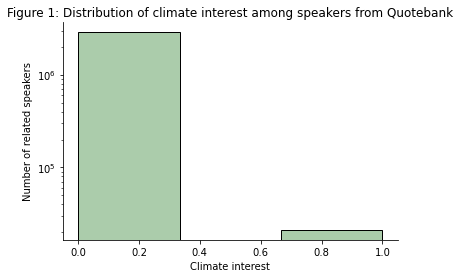

In [149]:
ax=sns.histplot(speakers['climate'],  bins=3, color = "darkseagreen" )
ax.set(xlabel='Climate interest', ylabel='Number of related speakers', 
       title= 'Figure 1: Distribution of climate interest among speakers from Quotebank')
ax.set_yscale('log') #We use a log scale in order to see the small values. 
sns.despine()

> 0: Show no climate interest 
> 1: Show climate interest

We can observe that speakers related to climate are a minority of the speakers from the original quotebank dataset.
Consequently, if we want to compare the type of personnes involved in climate vs not invovled we need to normalize our data and look for the probability.

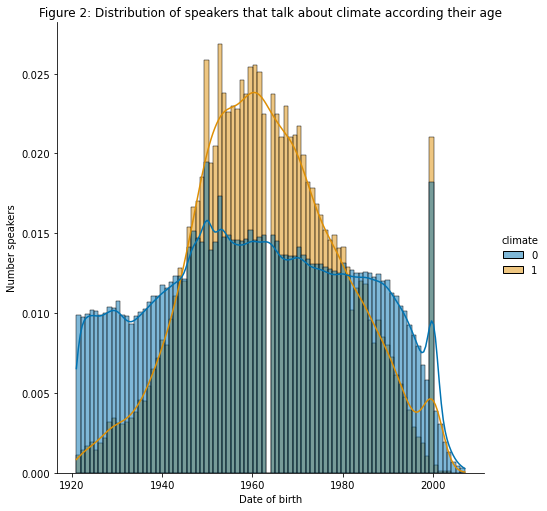

In [103]:
#We used displot function in order to visualize the age of people related to climate or not
ax=sns.displot(speakers, x="date_of_birth", hue="climate", stat="probability", common_norm=False,
            height=7, aspect=1, palette='colorblind',  kde=True, bins = 88)
ax.set(xlabel='Date of birth', ylabel='Number speakers', 
       title = 'Figure 2: Distribution of speakers that talk about climate according their age')


In [104]:
gender= speakers[speakers['gender'].apply(lambda x: x != '[]')]

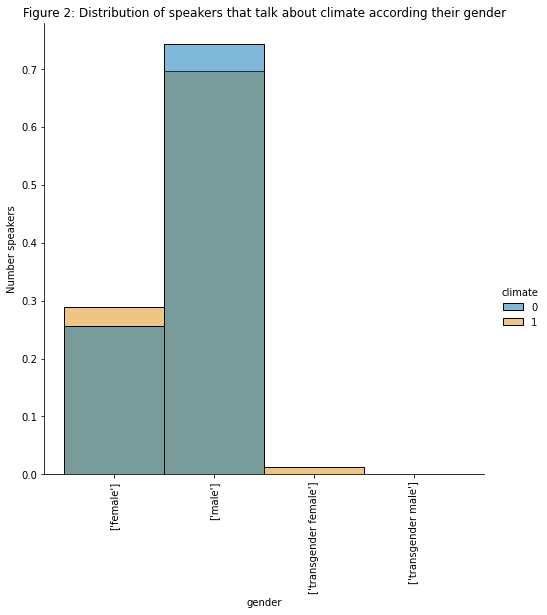

In [146]:
ax=sns.displot(gender.sample(10000), x="gender", hue="climate", stat="probability", common_norm=False,
            height=7, aspect=1, palette='colorblind', bins = 100)

#We let the default number of bins as it represents accuratly our data.
ax.set(xlabel='gender', ylabel='Number speakers', 
       title = 'Figure 2: Distribution of speakers that talk about climate according their gender')

plt.xticks(rotation=90)
plt.show()

In [129]:
religion= speakers[speakers['religion'].apply(lambda x: x != '[]')]

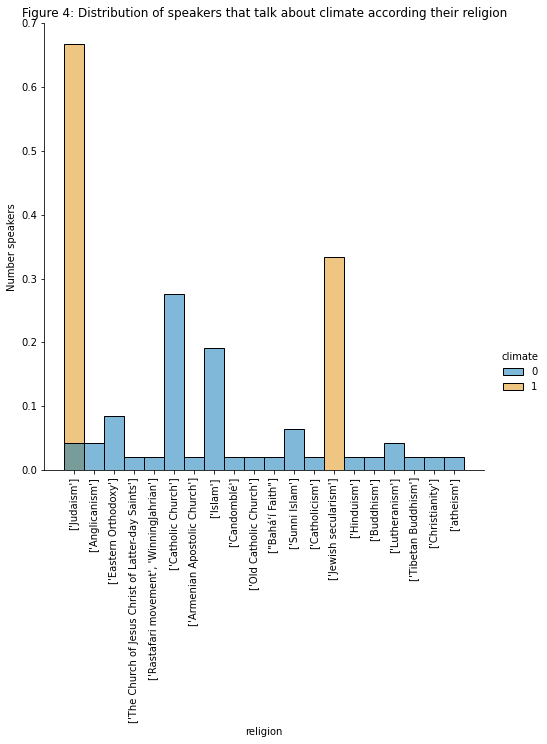

In [143]:
ax=sns.displot(religion.sample(50), x="religion", hue="climate", stat="probability", common_norm=False,
            height=7, aspect=1, palette='colorblind', bins = 100)

#We let the default number of bins as it represents accuratly our data.
ax.set(xlabel='religion', ylabel='Number speakers', 
       title = 'Figure 4: Distribution of speakers that talk about climate according their religion')

plt.xticks(rotation=90)
plt.show()

In [132]:
nationality= speakers[speakers['nationality'].apply(lambda x: x != '[]')]

No handles with labels found to put in legend.


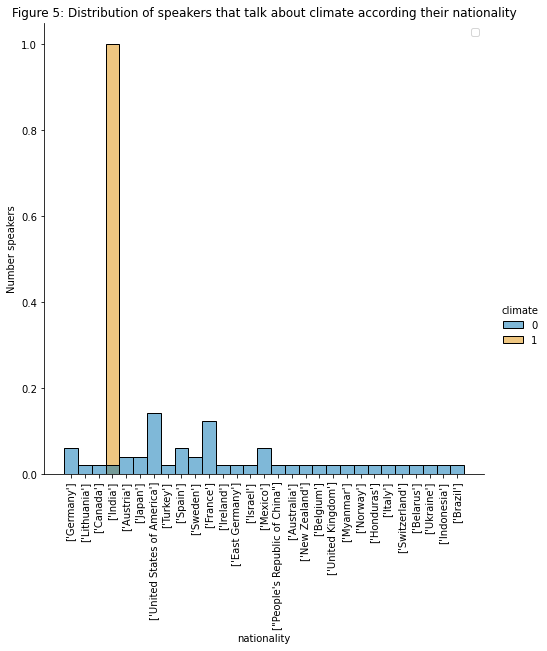

In [142]:
ax=sns.displot(nationality.sample(50), x="nationality", hue="climate", stat="probability", common_norm=False,
            height=7, aspect=1, palette='colorblind', bins = 100)

#We let the default number of bins as it represents accuratly our data.
ax.set(xlabel='nationality', ylabel='Number speakers', 
       title = 'Figure 5: Distribution of speakers that talk about climate according their nationality')

plt.xticks(rotation=90)
plt.legend()
plt.show()

After visualizing our data, we cannot conclude anything on their distributions.

In [134]:
involved=speakers.loc[speakers['climate']==1]

In [135]:
sceptic=speakers.loc[speakers['skeptic']==1]

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


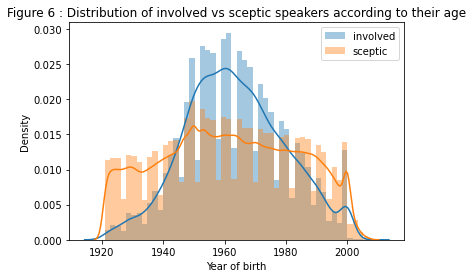

In [140]:
ax=sns.distplot(involved['date_of_birth'], hist=True, label = 'involved'); 
ax=sns.distplot(speakers['date_of_birth'], hist = True, label = 'sceptic')

ax.set(title = 'Figure 6 : Distribution of involved vs sceptic speakers according to their age', xlabel = 'Year of birth')
plt.legend()
plt.show()

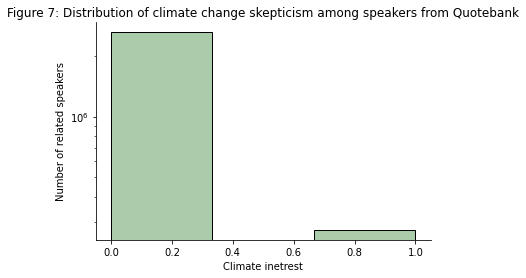

In [147]:
ax=sns.histplot(speakers['skeptic'],  bins=3, color = "darkseagreen" )
ax.set(xlabel='Climate interest', ylabel='Number of related speakers', 
       title= 'Figure 7: Distribution of climate change skepticism among speakers from Quotebank')
ax.set_yscale('log') #We use a log scale in order to see the small values. 

sns.despine()

> 0: Show no climate interest 
> 1: Show climate change scepticism tendancies

In [155]:
gender= speakers[speakers['gender'].apply(lambda x: x != '[]')]

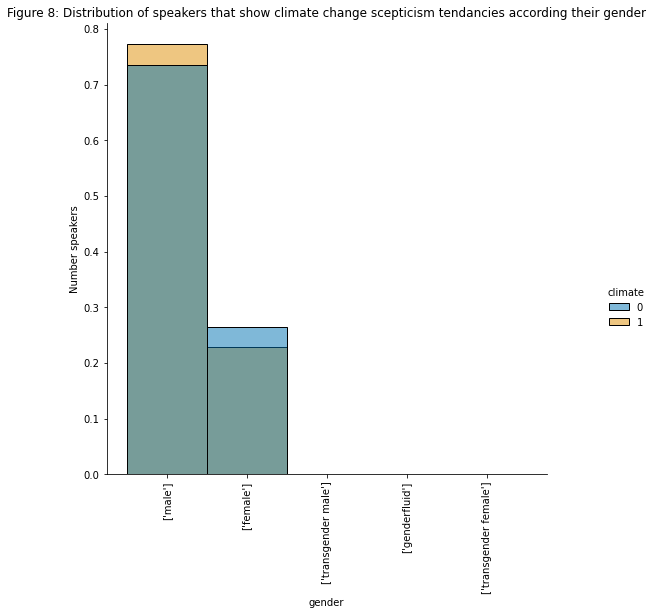

In [156]:
ax=sns.displot(gender.sample(10000), x="gender", hue="climate", stat="probability", common_norm=False,
            height=7, aspect=1, palette='colorblind', bins = 100)

#We let the default number of bins as it represents accuratly our data.
ax.set(xlabel='gender', ylabel='Number speakers', 
       title = 'Figure 8: Distribution of speakers that show climate change scepticism tendancies according their gender')

plt.xticks(rotation=90)
plt.show()

We can see that sceptic speakers follow a more uniform distribution than the involved ones. As we saw before, our key word list is faulty and we obtained a population that is not representative for the sceptic speakers.

# IV-Methods

## Datas loading and treatment 

We loaded our datas from the big quotebanke dataset by selecting different quotations according to two sets of keywords. Our method to select the climate skeptic people is not yet robust and we will describe below another method. Now that we have these datasets, we need to treat them in order to avoid high bias from unseen correlations.

### MTEXT: Semi-supervised BERT-based model (for climate change denial detection), and BERT (for climate topic detection): No mathematical model yet (we are waiting for the code for MTEXT)

As for now, we used a very unprecised and bias method to categorize our quotes as climat-change skeptical. For the rest of this project,we would like to use an automatic classification of climate change scepticism people. According to https://aclanthology.org/2021.naacl-main.175.pdf, neutralization is used in climate skepticism. 
Naturalization example : 

- Sure, we should reduce greenhouse gases, but if our climate policies hurt our ability to create more wealth and bring power to the world’s poor, then we are ridding the patient of the disease, but only by killing him
- It’s very convenient for alarmist greens to blame the fires of Australia and California on global warming. In reality, global warming is just a natural cycle and the policies they themselves advocate are the culprits.
- The IPCC falsely attributes natural warming and urban warming to greenhouse gas (GHG) emission warming. It ignores the compelling evidence of natural climate change before 1950 that correlates well with indicators of solar activity

They could categorize these neutralization techniques arguments into two groups
- Policy (cost, economy, carbon tax) -> blame alarmist green 
    - Condemnation of the Condemner (manipulation of poltics)
    - Appeal to Higher Loyalties (progress is more important than taxes)
    - Justification by Comparison (pollution comparison)
- Science (ability of scientist) -> natural cycle
    - Denial of responsability (natural cycle)
    - Denial of injury1 (not significant)
    - Denial of injury2 (increase of CO2 is good)
    - Denial of victim 
As for the code, we will based ourself on the code generously provided by the writers of the article. As they haven't linked us the code yet, it will be difficult for us to provied a detailed descrption of the model.

Concerning the climate topic detection, will will use a BERTbase model to sort our quotes, trained using dataset provided in the article https://www.sustainablefinance.uzh.ch/dam/jcr:cabd56b0-b93f-4577-80e3-5afe51a61faf/CLIMATEXT%20-%20A%20DATASET%20FOR%20CLIMATE%20CHANGE%20TOPIC%20DETECTION.pdf. This will enable us to eliminate the bias caused by our keywords choice. 

## Project

Our data set is now all clear and we are ready to find a suitable machine learning method in order to analyze our different categories of interest.
- Climate skeptic 
- Climate involved 

### Propensity score matching

The propensity score is the conditional probability of receiving a treatment given backgrounds variables: 

$ e(x)= Pr(Z=1|X=x) $

This e(x) is a balancing score in order to balance our whole data set, we are not trying to predict anything here. 
We will use the statsmodels package to find our propensity scores. We will need the networkx package to find our matching function, (maximal matching, perfect matching our valid matching, etc). In order to minimize the difference between two propensity score of a treated and untreated particpant, we will use a similarity function that will calculate the distance betweem two instances.$sim(x,y) = 1 - (propensityscore(x) - propensityscore(y))$

Description source : wikipedia, tutorials observational studies.

### Logistic Regression

In this method, we will fit a binary dependent variable model. This will categorize our prediction in two different output 1 or 0, for example climate skeptik or not. We assume t is a linear function with a unique explanatory variable and two parameters to be estimated (maximum likelihood estimator),

$ t = \beta_{0}+\beta _{1}x $

 $p(x) = \frac{1}{1 + exp(-t)} $

p(x) is the probability of sucess or failure (our binary output).  
If we want to to have to have multiple explanatory variables, we can use: 

$t = {\displaystyle \beta _{0}+\beta _{1}x_{1}+\beta _{2}x_{2}+\cdots +\beta _{m}x_{m}=\beta _{0}+\sum _{i=1}^{m}\beta _{i}x_{i}}$

We will use the sklearn method for this logistic regression. 

Description source : Wikipedia.

### Tree Classifier

A decision tree is a very visual model to describe how a set of inputs leads to a certain output (here category). This method allows us to have a good insight of how our output is chosen as every parameter is represented by a node.

1) Random Forest: This method constructs several decision trees in parallel in the training time. The final output will be the one represented by most trees. The advantage of this methods is that it reduces the variance as it is trained on different subset of the same training set. In order to select a random sample, it uses the bagging technique which select randomly x time a number n of instances with replacement. The model is fitted on these x instances.

We will use the sklearn.ensemble.RandomForestClassifier.

2) Gradient boosting: This method fits a prediction model based on the combination of weak learner classifier (here decision tree). The principle is to introduce a function that will approximate the output from the input. The methods fits sequentially a serie of tree where a loss function is minimize at each steps in order to increase the performance through the process. 

We will use sklearn.ensemble.GradientBoostingClassifier.

Descrition source : Wikipedia.